## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [8]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [11]:
original_data

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,Return to Owner,Neutered Male,10.000000,Dog,Normal,Stray,Neutered Male,10.000000,2017,1.0,0.588194
1,Return to Owner,Neutered Male,7.000000,Dog,Normal,Public Assist,Neutered Male,7.000000,2014,2.0,1.259722
2,Return to Owner,Neutered Male,6.000000,Dog,Normal,Public Assist,Neutered Male,6.000000,2014,3.0,1.113889
3,Transfer,Neutered Male,10.000000,Dog,Normal,Owner Surrender,Neutered Male,10.000000,2014,1.0,4.970139
4,Return to Owner,Neutered Male,16.000000,Dog,Injured,Public Assist,Neutered Male,16.000000,2013,1.0,0.119444
...,...,...,...,...,...,...,...,...,...,...,...
79667,Transfer,Unknown,0.038356,Cat,Normal,Stray,Unknown,0.038356,2018,1.0,0.077083
79668,Euthanasia,Unknown,2.000000,Other,Normal,Wildlife,Unknown,2.000000,2018,1.0,0.053472
79669,Euthanasia,Unknown,1.000000,Other,Normal,Wildlife,Unknown,1.000000,2018,1.0,0.047917
79670,Return to Owner,Intact Male,0.821918,Dog,Normal,Stray,Intact Male,0.410959,2018,1.0,1.762500


In [9]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 79672
The length of the data without the rows with nan value is: 79661


In [10]:
data_features = original_data.copy()
data_features['adopted'] = data_features.outcome_type.apply(lambda r: 1 if r=='Adoption' else 0)
data_features.drop("outcome_type", axis = 1, inplace=True)
data_features.head()

,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted
0,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194,0
1,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722,0
2,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889,0
3,Neutered Male,10.0,Dog,Normal,Owner Surrender,Neutered Male,10.0,2014,1.0,4.970139,0
4,Neutered Male,16.0,Dog,Injured,Public Assist,Neutered Male,16.0,2013,1.0,0.119444,0


In [21]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [22]:
[train, test] = split_set(data_features)

### Standardize the values of each feature in the data to have mean 0 and variance 1.

In [35]:
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns=categorical_columns) 
# pandas.get_dummies() is used for data manipulation. It converts categorical data into dummy or indicator variables.
# en gros ça fait des features avec tes donnéesex_upon_outcome_Neutered Male
train_categorical.columns

Index(['age_upon_outcome_(years)', 'age_upon_intake_(years)', 'intake_year',
       'intake_number', 'time_in_shelter_days', 'adopted',
       'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male',
       'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female',
       'sex_upon_outcome_Unknown', 'animal_type_Bird', 'animal_type_Cat',
       'animal_type_Dog', 'animal_type_Other', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife',
       'sex_upon_intake_Intact Female', 'sex_upon_intake_Intact Male',
       'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female',
       'sex_upon_intake_Unknown'],
      dtype='object')

In [36]:
train_categorical

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,10.000000,10.000000,2017,1.0,0.588194,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,7.000000,7.000000,2014,2.0,1.259722,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,6.000000,6.000000,2014,3.0,1.113889,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,16.000000,16.000000,2013,1.0,0.119444,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,15.000000,15.000000,2013,1.0,0.870833,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63491,0.038356,0.038356,2018,1.0,0.708333,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
63492,0.038356,0.038356,2018,1.0,0.077083,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
63493,2.000000,2.000000,2018,1.0,0.053472,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
63494,1.000000,1.000000,2018,1.0,0.047917,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [32]:
test_categorical = pd.get_dummies(test, columns=categorical_columns)[train_categorical.columns]
# just to be sure 

In [37]:
train_label=train_categorical.adopted
train_features = train_categorical.drop('adopted', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.adopted
test_features = test_categorical.drop('adopted', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 63496
Length of the test dataset : 16165


In [39]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]


### Stardize train data set

In [40]:
train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,2.716728,2.735225,1.197246,-0.279603,-0.388163,-0.364727,-0.374142,1.345650,-0.683862,-0.305521,...,-0.05607,-0.483123,-0.259703,0.652985,-0.212929,-0.649576,-0.683912,2.292258,-0.402323,-0.305521
1,1.680206,1.696254,-1.101593,1.928563,-0.372041,-0.364727,-0.374142,1.345650,-0.683862,-0.305521,...,-0.05607,-0.483123,3.850492,-1.531406,-0.212929,-0.649576,-0.683912,2.292258,-0.402323,-0.305521
2,1.334699,1.349930,-1.101593,4.136728,-0.375542,-0.364727,-0.374142,1.345650,-0.683862,-0.305521,...,-0.05607,-0.483123,3.850492,-1.531406,-0.212929,-0.649576,-0.683912,2.292258,-0.402323,-0.305521
3,4.789770,4.813168,-1.867873,-0.279603,-0.399417,-0.364727,-0.374142,1.345650,-0.683862,-0.305521,...,-0.05607,-0.483123,3.850492,-1.531406,-0.212929,-0.649576,-0.683912,2.292258,-0.402323,-0.305521
4,4.444263,4.466844,-1.867873,-0.279603,-0.381377,-0.364727,-0.374142,-0.743124,1.462261,-0.305521,...,-0.05607,-0.483123,-0.259703,0.652985,-0.212929,-0.649576,-0.683912,-0.436244,2.485525,-0.305521


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [54]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    '''
    
    
    '''
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix

def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


In [48]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,train_label)

LogisticRegression(max_iter=10000)

In [51]:
'''Assuming your target is (0,1), then the classifier would output a probability 
matrix of dimension (N,2). The first index refers to the probability that the data belong to class 0,
and the second refers to the probability that the data belong to class 1.'''
prediction_proba = logistic.predict_proba(test_features_std)
prediction_proba


array([[0.76778754, 0.23221246],
       [0.92939504, 0.07060496],
       [0.92584259, 0.07415741],
       ...,
       [0.86670605, 0.13329395],
       [0.98662718, 0.01337282],
       [0.71695391, 0.28304609]])

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

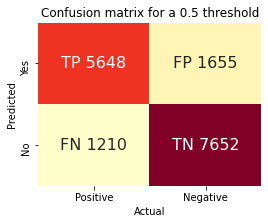

In [52]:
confusion_matrix_05 = compute_confusion_matrix(test_label, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [55]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.823
For the positive case, the precision is 0.773, the recall is 0.824 and the F1 score is 0.798
For the negative case, the precision is 0.863, the recall is 0.822 and the F1 score is 0.842


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [58]:
threshold = np.linspace(0, 1, 100)

In [60]:
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(test_label, prediction_proba, t ),t)] # attention au crochet!!
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)
threshold_score

,Accuracy,Precision P,Recall P,F1 score P,Precision N,Recall N,F1 score N
Threshold,,,,,,,
0.000000,0.424250,0.424250,1.000000,0.595752,NaN,0.000000,NaN
0.010101,0.506403,0.462213,0.999708,0.632152,0.998498,0.142903,0.250023
0.020202,0.526075,0.472320,0.998979,0.641389,0.995783,0.177608,0.301450
0.030303,0.538880,0.479143,0.998250,0.647498,0.993607,0.200387,0.333512
0.040404,0.556264,0.488746,0.997375,0.656021,0.991705,0.231224,0.375011
...,...,...,...,...,...,...,...
0.959596,0.588432,0.901961,0.033537,0.064670,0.583407,0.997314,0.736170
0.969697,0.585586,0.911917,0.025663,0.049922,0.581643,0.998173,0.734997
0.979798,0.583112,0.916084,0.019102,0.037423,0.580140,0.998711,0.733941


Text(0.5, 1.0, 'Accuracy')

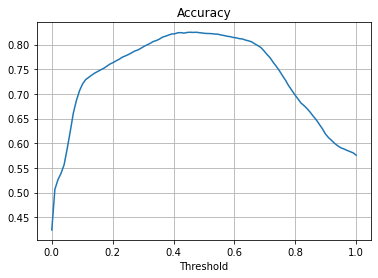

In [61]:
threshold_score['Accuracy'].plot(grid=True).set_title('Accuracy')


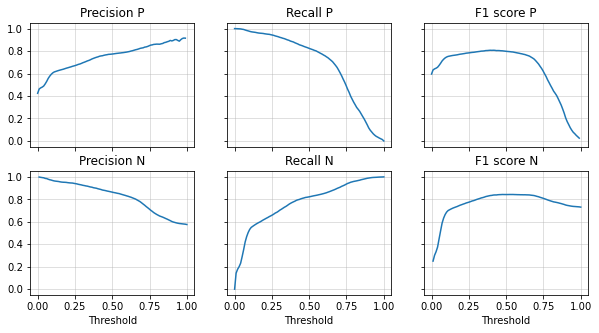

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [63]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)

LogisticRegression(max_iter=10000)

In [71]:
logistic.coef_[0]

array([ 1.22187023e+00, -1.59639687e+00,  2.00902365e-01,  5.00134029e-02,
        7.70681848e-01, -6.83938729e-01, -7.74665576e-01,  6.43608931e-01,
        6.56335994e-01, -4.99340862e-01,  2.26206563e-01, -3.48471348e-02,
       -5.74899223e-02,  1.35382866e-01,  3.62358628e-02, -6.91998449e-02,
       -6.36117894e-02,  7.24111606e-02, -1.44334584e-03, -5.65680560e-03,
        2.12222291e-02, -5.02688753e-02, -3.62906330e-02,  4.45866316e-01,
       -3.43568589e-01,  1.36153942e-01, -7.43063799e-01,  3.54912871e-01,
        3.41229952e-01, -2.86829925e-01, -2.20850132e-01, -4.99340862e-01])

In [78]:
table = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]): # simplement pour enlever une des braquette
    table.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(table).sort_values("value",ascending=True)
features_coef.head()
table

[{'name': 'age_upon_outcome_(years)', 'value': 1.2218702287049552},
 {'name': 'age_upon_intake_(years)', 'value': -1.5963968692590556},
 {'name': 'intake_year', 'value': 0.20090236508201237},
 {'name': 'intake_number', 'value': 0.050013402925251964},
 {'name': 'time_in_shelter_days', 'value': 0.7706818484130784},
 {'name': 'sex_upon_outcome_Intact Female', 'value': -0.6839387291125804},
 {'name': 'sex_upon_outcome_Intact Male', 'value': -0.7746655764117713},
 {'name': 'sex_upon_outcome_Neutered Male', 'value': 0.6436089308311485},
 {'name': 'sex_upon_outcome_Spayed Female', 'value': 0.6563359938460628},
 {'name': 'sex_upon_outcome_Unknown', 'value': -0.49934086199458866},
 {'name': 'animal_type_Bird', 'value': 0.22620656323945887},
 {'name': 'animal_type_Cat', 'value': -0.03484713480933359},
 {'name': 'animal_type_Dog', 'value': -0.05748992229615947},
 {'name': 'animal_type_Other', 'value': 0.1353828660726446},
 {'name': 'intake_condition_Aged', 'value': 0.0362358628394552},
 {'name': 

<BarContainer object of 32 artists>

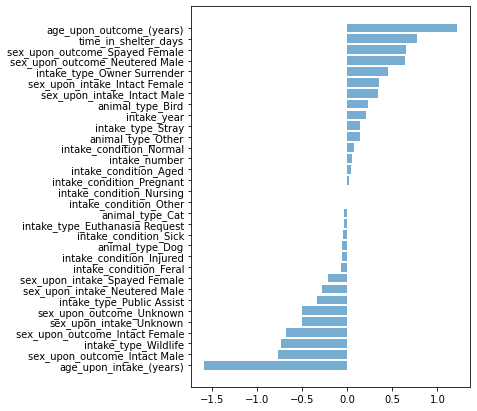

In [79]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)

# Quiz

## Questions 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95